# Rotor Estimation

In [1]:
import sys
sys.path.append('../build/Debug/')
from transformations import (quaternion_matrix as quaternion_to_matrix,
                             euler_matrix as euler_to_matrix, 
                             euler_from_quaternion)
import librotor_estimation as rotor_estimation
%pylab inline
np.set_printoptions(precision=6, suppress=True)
from ipy_table import *

Populating the interactive namespace from numpy and matplotlib


In [2]:

fig_width_pt = 358.50475  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (sqrt(5.0)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]
params = {
    'axes.labelsize': 9,
    'font.size': 9,
    "font.family": "serif",
    "font.serif": [],
    'legend.fontsize': 9,
    'legend.linewidth': 0.3,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'text.latex.preamble':[r'\usepackage{amsmath}', r'\usepackage{bm}'],
    'figure.figsize': fig_size,
    'axes.linewidth': 0.5
}
 
 
matplotlib.rcParams.update(params)
np.set_printoptions(suppress=True)

## Introduction

### Dataset generation

In [80]:
r = euler_to_matrix(0.0,0.0,np.pi/3.0)[:3,:3]

In [81]:
def generate_dataset(n_points, sigma, mu):
    n_points = n_points
    r = euler_to_matrix(0.0,0.0,np.pi/3.0)[:3,:3]
#     angles = np.pi * np.random.randn(3)
#     r = euler_to_matrix(angles[0], angles[1], angles[2])[:3,:3]
    points_a = np.random.normal(0.0,0.8,(n_points,3))
    points_a = np.array([point / np.linalg.norm(point) for point in points_a])
    points_b = np.array([np.dot(r,point.reshape(3,1)).reshape(3) for point in points_a])
    # Add noise to the rotated point cloud
    sigma = sigma
    mu = mu
    points_b_noisy = points_b + sigma * np.random.randn(n_points,3) + mu
    points_b_noisy = np.array([point / np.linalg.norm(point) for point in points_b_noisy])
    return (points_a, points_b, points_b_noisy)

In [82]:
(points_a, points_b, points_b_noisy) = generate_dataset(10, 0.0, 0.0)

## Non-Linear Least Squares Rotor estimation

In [83]:
def create_solver_options(use_trust_region_minimizer=True):
    solver_options = {
        'minimizer_type':'TRUST_REGION',
        'trust_region_strategy_type':'LEVENBERG_MARQUARDT',
        'linear_solver_type':'DENSE_QR',
        'max_num_iterations': 100, 
        'num_threads': 12,
        'num_linear_solver_threads':12,
        'parameter_tolerance': 10e-16,
        'function_tolerance': 10e-16,
        'minimizer_progress_to_stdout':False,
        'trust_region_minimizer_iterations_to_dump':[],
        'trust_region_problem_dump_directory':'/home/lars/devel/game_ws/dump/sphere_fit',
    }
    return solver_options  
solver_options = create_solver_options()

### Estimate full rotor 
$$ R = \cos \left( \frac{\theta}{2} \right) - \sin \left( \frac{\theta}{2} \right)  B  $$

In [84]:
rotor_parameters = np.array([1.0, 0.0, 0.0, 0.0]).reshape(4,1)
re = rotor_estimation.RotorEstimation(solver_options)
rotor_1 = re.run(rotor_parameters.copy(), points_a, points_b_noisy)
print(rotor_1.ravel())

[ 0.866025 -0.5      -0.       -0.      ]


### Estimate the bivector generator
$$ R = \exp \left( - \frac{\theta}{2} B \right) $$

In [35]:
bivector_parameters = np.array([0.0,0.0,1.0]).reshape(3,1)
rbe = rotor_estimation.RotorBivectorGeneratorEstimation()
rotor_2 = rbe.run(bivector_parameters.copy(), points_a, points_b_noisy)
print(rotor_2.ravel())

[ 0.866025 -0.5       0.        0.      ]


In [36]:
quaternion_parameters = np.array([1.0, 0.0, 0.0, 0.0]).reshape(4,1)
qe = rotor_estimation.QuaternionEstimation(solver_options)
quaternion = qe.run(quaternion_parameters.copy(), points_a, points_b_noisy)
print(quaternion.ravel())

[ 0.866025 -0.        0.        0.5     ]


### SVD using tensor representation

In [37]:
def rotor_estimation_ls_svd(points_a, points_b_noisy):
    
    gp_table = np.array([1,  2,  3,  4,  5,  6,  7,  8,
                         2,  1,  7, -6,  8, -4,  3,  5,
                         3, -7,  1,  5,  4,  8, -2,  6,
                         4,  6, -5,  1, -3,  2,  8,  7,
                         5,  8, -4,  3, -1, -7,  6, -2,
                         6,  4,  8, -2,  7, -1, -5, -3,
                         7, -3,  2,  8, -6,  5, -1, -4, 
                         8,  5,  6,  7, -2, -3, -4, -1]).reshape(8,8)

    def gp_tensor():
        dim = 8
        tensor = np.zeros((8,8,8))
        for k in range(dim):
            for i in range(dim):
                for j in range(dim):
                    val = gp_table[i,j]
                    if abs(val) == k + 1:
                        tensor[k,i,j] = np.sign(val)
        return tensor

    def gp_left_matrix(multivector):
        tensor = gp_tensor()
        matrix = np.zeros((8,8))
        for i in range(8):
            t = tensor[i,:,:]
            matrix[i,:] = np.inner(t.T,multivector.T).reshape(-1)
        return matrix

    def gp_right_matrix(multivector):
        tensor = gp_tensor()
        matrix = np.zeros((8,8))
        for i in range(8):
            t = tensor[i,:,:]
            matrix[i,:] = np.inner(multivector.T,t).reshape(-1)
        return matrix

    A = [np.array([0.0, p[0], p[1], p[2], 0.0, 0.0, 0.0, 0.0]).reshape(8,1) for p in points_a]
    B = [np.array([0.0, p[0], p[1], p[2], 0.0, 0.0, 0.0, 0.0]).reshape(8,1) for p in points_b_noisy]

    gp_a = np.row_stack([gp_right_matrix(a) for a in A])
    b_gp = np.row_stack([gp_left_matrix(b) for b in B])
    m = gp_a - b_gp

    [U,s,Vt] = np.linalg.svd(m)
    names = ('sc', 'e1', 'e2', 'e3', 'e23', 'e31', 'e12', 'e123')
    res = np.recarray(1, formats = 8*['f8'], names=names, buf=Vt.T[:,-1])
    rotor = np.array([res['sc'], res['e12'], -res['e31'], res['e23']])
    return rotor

rotor_estimation_ls_svd(points_a.copy(), points_b_noisy.copy())

array([[ 0.693366],
       [-0.400315],
       [ 0.      ],
       [ 0.      ]])

### "*Least-squares estimation of transformation parameters between two point patterns*" by Shinji Umeyama

In [38]:
def umeyama(src, dst):
    '''
    Estimates transform between src and dst points.
    The algorithm is based on:
    "Least-squares estimation of transformation parameters between two point patterns",
    Shinji Umeyama, PAMI 1991, DOI: 10.1109/34.88573
    '''
    assert src.shape == dst.shape

    m = src.shape[0]
    n = src.shape[1]
    one_over_n = 1.0/n

    # compute mean
    src_mean = np.sum(src, axis=1) * one_over_n
    dst_mean = np.sum(dst, axis=1) * one_over_n

    # demean
    src_demean = src - src_mean[:,np.newaxis]
    dst_demean = dst - dst_mean[:,np.newaxis]


    # Eq. (36)-(37)
    src_var = np.sum(src_demean**2) * one_over_n

    # Eq. (38)
    sigma = one_over_n * np.dot(dst_demean, src_demean.T);

    U, d, Vt = np.linalg.svd(sigma)

    # Initialize the resulting transformation with an identity matrix...
    Rt = np.eye(m+1)

    # Eq. (39)
    S = np.ones(m);
    if np.linalg.det(sigma) < 0:
        S[m-1] = -1;
    
    # Eq. (40) and (43)
    rank = 0
    for i in range(m):
        if d[i] > 1e-12*d[0]:
            rank +=1

    if rank == m-1:
        if np.linalg.det(U) * np.linalg.det(Vt.T) > 0:
            Rt[0:m,0:m] = np.dot(U, Vt)
        else:
            s = S[m-1]
            S[m-1] = -1
            Rt[0:m,0:m] =  np.dot(np.dot(U, np.diag(S)), Vt)
            S[m-1] = s
    else:
        Rt[0:m,0:m] =  np.dot(np.dot(U, np.diag(S)), Vt)
    
    # Eq. (42)
    c = 1.0/src_var * np.dot(d, S);

    # Eq. (41)
    Rt[0:m,m] = dst_mean
    Rt[0:m,m] -= c*np.dot(Rt[0:m,0:m], src_mean)

    return Rt

umeyama_r = umeyama(points_a.T,points_b_noisy.T)[:3,:3]

### "*Least-Squares Fitting of Two 3-D Point Sets*" by K.S. Arun, T. S. Huang and S. D. Blostein

In [39]:
def estsimt(X1,X2):
    # from estsimt.m in MultiCameSelfCal

    # ESTimate SIMilarity Transformation
    #
    # [s,R,T] = estsimt(X1,X2)
    #
    # X1,X2 ... 3xN matrices with corresponding 3D points
    #
    # X2 = s*R*X1 + T
    # s ... scalar scale
    # R ... 3x3 rotation matrix
    # T ... 3x1 translation vector
    #
    # This is done according to the paper:
    # "Least-Squares Fitting of Two 3-D Point Sets"
    # by K.S. Arun, T. S. Huang and S. D. Blostein

    N = X1.shape[1]
    if N != X2.shape[1]:
        raise ValueError('both X1 and X2 must have same number of points')

    X1cent = np.mean(X1,axis=1)
    X2cent = np.mean(X2,axis=1)
    # normalize coordinate systems for both set of points
    x1 = X1 - X1cent[:,np.newaxis]
    x2 = X2 - X2cent[:,np.newaxis]

    # mutual distances
    d1 = x1[:,1:]-x1[:,:-1]
    d2 = x2[:,1:]-x2[:,:-1]
    ds1 = np.sqrt( np.sum( d1**2, axis=0) )
    ds2 = np.sqrt( np.sum( d2**2, axis=0) )

    scales = ds2/ds1
    s = np.median( scales )

    # undo scale
    x1s = s*x1

    # finding rotation
    H = np.zeros((3,3))
    for i in range(N):
        tmp1 = x1s[:,i,np.newaxis]
        tmp2 = x2[np.newaxis,:,i]
        tmp = np.dot(tmp1,tmp2)
        H += tmp

    U,S,Vt = np.linalg.svd(H)
    V = Vt.T
    X = np.dot(V,U.T)
    R=X

    T = X2cent - s*np.dot(R,X1cent)
    return s,R,T

(s, R, T) = estsimt(points_a.T,points_b_noisy.T)
R

array([[ 0.5     , -0.866025,  0.      ],
       [ 0.866025,  0.5     , -0.      ],
       [ 0.      , -0.      ,  1.      ]])

## Results

In [40]:
def rotor_to_quaternion(rotor):
    return np.array([-rotor[3], rotor[2], -rotor[1],rotor[0]]).ravel()
def rotor_to_matrix(rotor):
    return quaternion_to_matrix(rotor_to_quaternion(rotor.ravel()))[:3,:3]

### Non-Linear Least Squares Rotor Estimation 

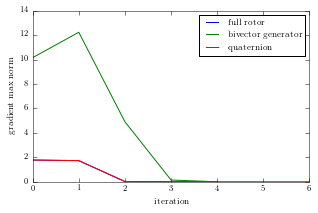

5
5
7


In [41]:
iterations_re = re.summary()['iterations']
plt.plot([iteration['gradient_max_norm'] for iteration in iterations_re], label='full rotor')
iterations_rbe = rbe.summary()['iterations']
plt.plot([iteration['gradient_max_norm'] for iteration in iterations_rbe],label='bivector generator')
iterations_qe = qe.summary()['iterations']
plt.plot([iteration['gradient_max_norm'] for iteration in iterations_qe],label='quaternion')
plt.legend()
plt.xticks([iteration['iteration'] for iteration in max(iterations_rbe, iterations_re)])
plt.xlabel('iteration')
plt.ylabel('gradient max norm')

plt.show()

print(len(iterations_re))
print(len(iterations_qe))
print(len(iterations_rbe))

In [42]:
def rotor_euclidean_rms_distance(rotor, points_a, points_b):
    r = rotor_to_matrix(rotor)
    points_b_estimated = np.array([np.dot(r,point.reshape(3,1)).reshape(3) 
                                   for point in points_a])
    rms = np.sum([np.linalg.norm(pb - pbe) 
                  for pb, pbe in zip(points_b, points_b_estimated)]) / np.sqrt(len(points_a))
    return rms
def quaternion_euclidean_rms_distance(quaternion, points_a, points_b):
    r = quaternion_to_matrix(np.array([quaternion[1], 
                                       quaternion[2], 
                                       quaternion[3], 
                                       quaternion[0]]).ravel())[:3,:3]
    points_b_estimated = np.array([np.dot(r,point.reshape(3,1)).reshape(3) 
                                   for point in points_a])
    rms = np.sum([np.linalg.norm(pb - pbe) 
                  for pb, pbe in zip(points_b, points_b_estimated)]) / np.sqrt(len(points_a))
    return rms
def matrix_euclidean_rms_distance(matrix, points_a, points_b):
    points_b_estimated = np.array([np.dot(matrix,point.reshape(3,1)).reshape(3) 
                                   for point in points_a])
    rms = np.sum([np.linalg.norm(pb - pbe) 
                  for pb, pbe in zip(points_b, points_b_estimated)]) / np.sqrt(len(points_a))
    return rms

In [43]:
def euclidean_rms(f, points):
    (points_a, points_b, points_b_noisy) = points 
    r = f(points_a, points_b_noisy)
    points_b_estimated = np.array([np.dot(r,point.reshape(3,1)).reshape(3) 
                                   for point in points_a])
#     rms = np.sum([np.linalg.norm(pb - pbe) 
#                   for pb, pbe in zip(points_b, points_b_estimated)]) / np.sqrt(len(points_a))
    
    rms = np.sum([np.arccos(np.dot(pb, pbe)) 
                  for pb, pbe in zip(points_b, points_b_estimated)]) / np.sqrt(len(points_a))
    
    return rms

In [44]:
nls_r_1 = lambda points : euclidean_rms(lambda points_a, points_b_noisy: 
                            rotor_to_matrix(rotor_estimation.RotorEstimation(solver_options)
                                            .run(rotor_parameters.copy(), points_a, points_b_noisy)),
                            points)

In [45]:
nls_r_2 = lambda points : euclidean_rms(lambda points_a, points_b_noisy : 
                            rotor_to_matrix(rotor_estimation.RotorBivectorGeneratorEstimation()
                                            .run(bivector_parameters.copy(), points_a, points_b_noisy)), 
                                 points)

In [46]:
nls_q = lambda points : euclidean_rms(lambda points_a, points_b_noisy : 
                            quaternion_to_matrix(np.roll(rotor_estimation.QuaternionEstimation(solver_options)
                                                         .run(quaternion_parameters.copy(), 
                                                              points_a, 
                                                              points_b_noisy).ravel(), -1))[:3,:3],
                            points)

In [47]:
ls_svd = lambda points : euclidean_rms(lambda points_a, points_b_noisy : 
                                rotor_to_matrix(rotor_estimation_ls_svd(points_a, points_b_noisy)), 
                                points)

In [48]:
um = lambda points : euclidean_rms(lambda points_a, points_b_noisy : 
                             umeyama(points_a.T,points_b_noisy.T)[:3,:3], 
                             points)

In [51]:
arun = lambda points : euclidean_rms(lambda points_a, points_b_noisy : 
                                     estsimt(points_a.T,points_b_noisy.T)[1],
                                    points)

In [78]:
solvers = [nls_r_1, nls_r_2, nls_q, ls_svd, um, arun]
n_points = 10
n_samples = 1000
sigma = 0.09
mu = 0.0
points_set = [generate_dataset(n_points, sigma, mu) for i in range(n_samples)]
means_and_stds = [(np.mean(l), np.std(l)) 
                  for l in [[solver(points) for points in points_set] for solver in solvers]]

t = [
    ['', 'Mean $\mu$', 'Std.dev. $\sigma$'],
    ['nls_r_1', means_and_stds[0][0],means_and_stds[0][1]], 
    ['nls_r_2', means_and_stds[1][0],means_and_stds[1][1]],
    ['nls_q',   means_and_stds[2][0],means_and_stds[2][1]],
    ['ls_svd',  means_and_stds[3][0],means_and_stds[3][1]],
    ['umeyama', means_and_stds[4][0],means_and_stds[4][1]],
    ['arun',    means_and_stds[5][0],means_and_stds[5][1]]
];
make_table(t)
apply_theme('basic_both')

,Mean $\mu$,Std.dev. $\sigma$
nls_r_1,0.1393,0.0624
nls_r_2,0.1393,0.0624
nls_q,0.1393,0.0624
ls_svd,1.0540,1.1854
umeyama,0.1455,0.0648
arun,0.1455,0.0648


In [79]:
solvers = [nls_r_1, nls_r_2, nls_q, ls_svd, um, arun]
n_points = 10
n_samples = 1000
sigma = 0.18
mu = 0.0
points_set = [generate_dataset(n_points, sigma, mu) for i in range(n_samples)]
means_and_stds = [(np.mean(l), np.std(l)) 
                  for l in [[solver(points) for points in points_set] for solver in solvers]]

t = [
    ['', 'Mean $\mu$', 'Std.dev. $\sigma$'],
    ['nls_r_1', means_and_stds[0][0],means_and_stds[0][1]], 
    ['nls_r_2', means_and_stds[1][0],means_and_stds[1][1]],
    ['nls_q',   means_and_stds[2][0],means_and_stds[2][1]],
    ['ls_svd',  means_and_stds[3][0],means_and_stds[3][1]],
    ['umeyama', means_and_stds[4][0],means_and_stds[4][1]],
    ['arun',    means_and_stds[5][0],means_and_stds[5][1]]
];
make_table(t)
apply_theme('basic_both')

,Mean $\mu$,Std.dev. $\sigma$
nls_r_1,0.2861,0.1187
nls_r_2,0.2861,0.1187
nls_q,0.2861,0.1187
ls_svd,1.1342,1.1096
umeyama,0.2978,0.1248
arun,0.3010,0.1649


In [ ]:
points_b - points_b_noisy
rms = np.sum([np.linalg.norm(pb - pbe) for pb, pbe in zip(points_b, points_b_noisy)]) / np.sqrt(len(points_b))
rms / 2.
np.linalg.norm(pb - pbe)

points_set[0]

np.mean([np.linalg.norm(p[1] - p[2]) for p in points_set]) / 2

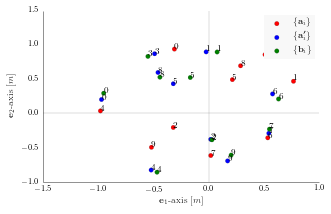

In [77]:
(points_a, points_b, points_b_noisy) = generate_dataset(10, 0.09, 0.0)

fig, ax = plt.subplots(1)

# ax.set_aspect('equal')
plt.set_cmap('gray')

almost_black = '#262626'
spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)
    ax.spines[spine].set_color(almost_black)
ax.xaxis.label.set_color(almost_black)
ax.yaxis.label.set_color(almost_black)

c = random.rand(n_points)

x = points_a[:,0]
y = points_a[:,1]
ax.scatter(x, y, c='r',
           edgecolor=almost_black, linewidth=0.15, 
           label=r"$\{\bm{\mathrm{a}}_i\}$")
for i, txt in enumerate(range(n_points)):
    ax.annotate(txt, (x[i],y[i]))
    
x = points_b[:,0]
y = points_b[:,1]
ax.scatter(x,y,c='b',
           edgecolor=almost_black,linewidth=0.15, 
           label=r"$\{\bm{\mathrm{a}^\prime}_i\}$")
for i, txt in enumerate(range(n_points)):
    ax.annotate(txt, (x[i],y[i]))
    
x = points_b_noisy[:,0]
y = points_b_noisy[:,1]
ax.scatter(x,y,c='g',
           edgecolor=almost_black,linewidth=0.15, 
           label=r"$\{\bm{\mathrm{b}}_i\}$")
for i, txt in enumerate(range(n_points)):
    ax.annotate(txt, (x[i],y[i]))
    
ax.title.set_color(almost_black)
ax.axhline(0, color=almost_black, linewidth=0.15)
ax.axvline(0, color=almost_black, linewidth=0.15)

# Remove the line around the legend box, and instead fill it with a light grey
# Also only use one point for the scatterplot legend because the user will 
# get the idea after just one, they don't need three.
light_grey = np.array([float(248)/float(255)]*3)
legend = ax.legend(frameon=True, scatterpoints=1)
rect = legend.get_frame()
rect.set_facecolor(light_grey)
rect.set_linewidth(0.0)

# Change the legend label colors to almost black, too
texts = legend.texts
for t in texts:
    t.set_color(almost_black)

plt.xlabel(r'$\bm{\mathrm{e}}_1$-axis $[m]$')
plt.ylabel(r'$\bm{\mathrm{e}}_2$-axis $[m]$')

save_dir = '/home/lars/Dropbox/sharelatex/2016_phd_thesis_lt/figures'
plt.show()
fig.savefig(save_dir + '/rotor_estimation_xy_proj.pdf')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
def plot_point_clouds(points_a, points_b):
    fig = plt.figure()
    almost_black = '#262626'   
    ax = plt.axes(projection='3d')
    ax.xaxis.label.set_color(almost_black)
    ax.yaxis.label.set_color(almost_black)

    spines_to_remove = ['bottom', 'right']
    for spine in spines_to_remove:
        ax.spines[spine].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    n = points_a.shape[0]
    x = points_a[:,0]
    y = points_a[:,1]
    z = points_a[:,2]
    c = x + y
    ax.scatter(x, y, z, c = c )
    x = points_b[:,0]
    y = points_b[:,1]
    z = points_b[:,2]
     
    ax.scatter(x, y, z, c = c)
    ax.set_xlabel('$x$-axis')
    ax.set_ylabel('$y$-axis')
    ax.set_zlabel('$z$-axis')
    
plot_point_clouds(points_a, points_b)

In [ ]:
# fig = plt.figure()
# x = points_b[:,0]
# y = points_b[:,1]
# c = x + y
# plt.scatter(x, y, c = c)
# x = points_b_estimated[:,0]
# y = points_b_estimated[:,1]
# plt.scatter(x,y,c = c)
# plt.show()